# Objective: fine-tuning detectron2/DETR

-   This notebook can be found on my Github profile: https://github.com/woctezuma/finetune-detr
-   Official DETR repository: https://github.com/facebookresearch/detr
-   Discussion about fine-tuning in [a Github issue](https://github.com/facebookresearch/detr/issues/9).
-   A nice blog post about another approach (Mask R-CNN) and the balloon dataset (which we use in this notebook): [here](https://engineering.matterport.com/splash-of-color-instance-segmentation-with-mask-r-cnn-and-tensorflow-7c761e238b46).

In [1]:
from google.colab import drive


drive.mount("/content/drive",force_remount=True)
!cp -r /content/drive/MyDrive/Colab\ Notebooks/crapaud/coco_subset . && echo "Copied !"
BASE_PATH = "/content/coco_subset/"
BASE_DRIVE = "/content/drive/MyDrive/Colab Notebooks/crapaud/coco_subset"

Mounted at /content/drive
Copied !


## Install detectron 2

In [2]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 274 kB 32.8 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp38-cp38-linux_x86_64.whl size=44089 sha256=1ba1d3be004410ee1476b2ab679ead328859d9da4d6358414da37bda2a2c6c96
  Stored in directory: /root/.cache/pip/wheels/52/dd/2b/10ff8b0ac81b93946bb5fb9e6749bae2dac246506c8774e6cf
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.2.1 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
Cloning into 'detectron2'...
remote: Enumerating objects: 14634, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 

In [3]:
#!pip install Pillow==7.2.0 pyyaml==5.3.1

In [4]:
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

In [5]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

## Create DETR config

In [6]:
%cd /content/

!git clone https://github.com/facebookresearch/detr

%cd detr/


!python d2/converter.py --source_model https://dl.fbaipublicfiles.com/detr/detr-r101-dc5-a2e86def.pth --output_model converted_model.pth

/content
Cloning into 'detr'...
remote: Enumerating objects: 260, done.
remote: Total 260 (delta 0), reused 0 (delta 0), pack-reused 260
Receiving objects: 100% (260/260), 12.87 MiB | 10.55 MiB/s, done.
Resolving deltas: 100% (120/120), done.
/content/detr
Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r101-dc5-a2e86def.pth" to /root/.cache/torch/hub/checkpoints/detr-r101-dc5-a2e86def.pth
100% 232M/232M [00:17<00:00, 13.8MB/s]
transformer.encoder.layers.0.self_attn.in_proj_weight -> detr.transformer.encoder.layers.0.self_attn.in_proj_weight
transformer.encoder.layers.0.self_attn.in_proj_bias -> detr.transformer.encoder.layers.0.self_attn.in_proj_bias
transformer.encoder.layers.0.self_attn.out_proj.weight -> detr.transformer.encoder.layers.0.self_attn.out_proj.weight
transformer.encoder.layers.0.self_attn.out_proj.bias -> detr.transformer.encoder.layers.0.self_attn.out_proj.bias
transformer.encoder.layers.0.linear1.weight -> detr.transformer.encoder.layers.0.linear1.weight
trans

In [7]:
from d2.detr import add_detr_config

cfg = get_cfg()

add_detr_config(cfg)
cfg.merge_from_file("d2/configs/detr_256_6_6_torchvision.yaml")

cfg.MODEL.WEIGHTS = "converted_model.pth"

## Define useful boilerplate functions

Adapted from:
-   https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/detr_attention.ipynb

## Prepare the dataset for fine-tuning

The `balloon` dataset will be used. It is featured here and uses VIA format:
-   https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon


You can choose whether to start indexing categories with 0 or with 1.

This is a matter of taste, and it should not impact the performance of the algorithm.

NB: this parameter matters a bit with vanilla DETR, but not with detectron2/DETR!

We expect the directory structure to be the following:
```
path/to/coco/
├ annotations/  # JSON annotations
│  ├ annotations/custom_train.json
│  └ annotations/custom_val.json
├ train2017/    # training images
└ val2017/      # validation images
```

- Documentation: https://detectron2.readthedocs.io/tutorials/datasets.html

In [8]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances("triton_train", {}, BASE_PATH +"annotations/train.json", BASE_PATH+"/train")
register_coco_instances("triton_val", {}, BASE_PATH +"annotations/val.json", BASE_PATH+"/val")

In [9]:
#cat_names = ["balloon"]

#for keyword in ['train', 'val']:
#  MetadataCatalog.get('custom_{}'.format(keyword)).set(thing_classes=cat_names)

custom_metadata = MetadataCatalog.get("triton_train")

## Check the dataset after it was pre-processed for fine-tuning

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:
-   Demo of COCO API: https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb

In [10]:
%cd ../

/content


WARNING [12/12 22:14:15 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/12 22:14:15 d2.data.datasets.coco]: Loaded 496 images in COCO format from /content/coco_subset/annotations/train.json


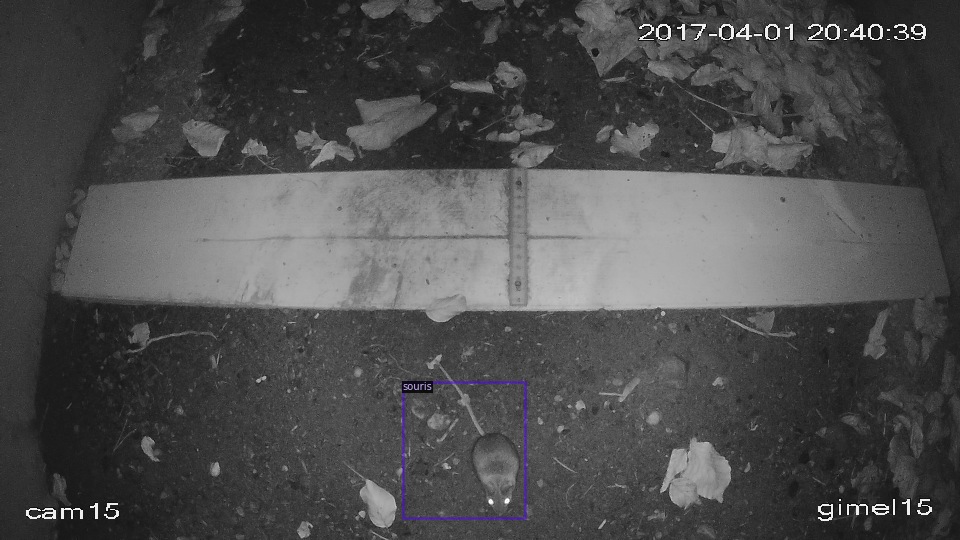

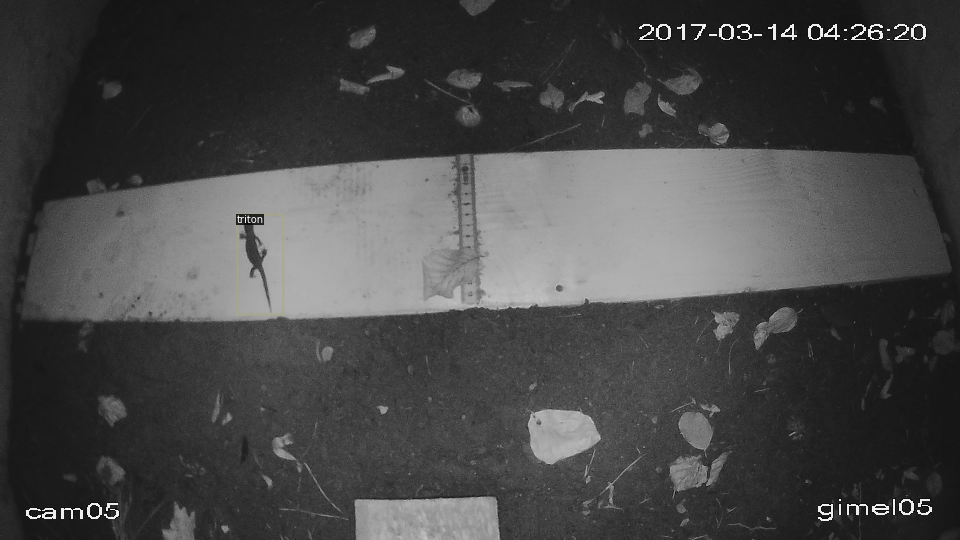

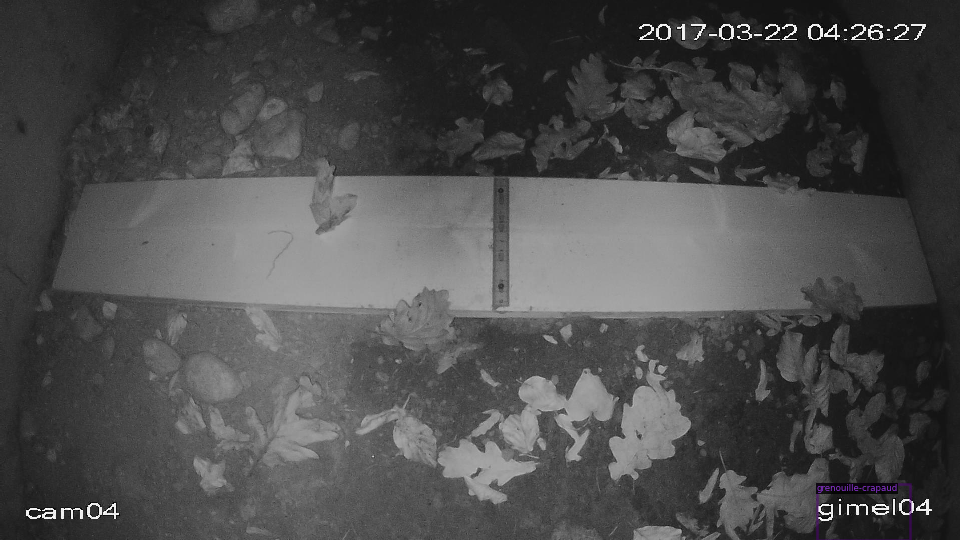

In [11]:
dataset_dicts = DatasetCatalog.get("triton_train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=custom_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

## Fine-tuning

-   The wrapper is here: https://github.com/facebookresearch/detr/tree/master/d2
-   A demo is showcased in [a Colab notebook](https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5).

Caveat: **this wrapper currently supports only box detection**.

In [12]:
%cd /content/detr/

/content/detr


In [13]:
from d2.detr import add_detr_config

cfg = get_cfg()

add_detr_config(cfg)
cfg.merge_from_file("/content/detr/d2/configs/detr_256_6_6_torchvision.yaml")

cfg.DATASETS.TRAIN = ("triton_train",)
cfg.DATASETS.TEST = ("triton_val",)

cfg.OUTPUT_DIR = '/content/outputs/'

cfg.MODEL.WEIGHTS = "/content/detr/converted_model.pth"
cfg.MODEL.DETR.NUM_CLASSES = 4

In [14]:
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # only has one class (ballon)

Caveat: use the `Trainer` provided by DETR.
-   https://github.com/facebookresearch/detr/issues/177

In [15]:
# from detectron2.engine import DefaultTrainer
from d2.train_net import Trainer

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = DefaultTrainer(cfg) 
trainer = Trainer(cfg) 
trainer.resume_or_load(resume=False)


[12/12 22:14:22 d2.engine.defaults]: Model:
Detr(
  (detr): DETR(
    (transformer): Transformer(
      (encoder): TransformerEncoder(
        (layers): ModuleList(
          (0): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
            )
            (linear1): Linear(in_features=256, out_features=2048, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=2048, out_features=256, bias=True)
            (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.1, inplace=False)
            (dropout2): Dropout(p=0.1, inplace=False)
          )
          (1): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=

criterion.empty_weight
detr.class_embed.{bias, weight}
  detr.backbone.0.backbone.res4.10.conv1.norm.{bias, running_mean, running_var, weight}
  detr.backbone.0.backbone.res4.10.conv1.weight
  detr.backbone.0.backbone.res4.10.conv2.norm.{bias, running_mean, running_var, weight}
  detr.backbone.0.backbone.res4.10.conv2.weight
  detr.backbone.0.backbone.res4.10.conv3.norm.{bias, running_mean, running_var, weight}
  detr.backbone.0.backbone.res4.10.conv3.weight
  detr.backbone.0.backbone.res4.11.conv1.norm.{bias, running_mean, running_var, weight}
  detr.backbone.0.backbone.res4.11.conv1.weight
  detr.backbone.0.backbone.res4.11.conv2.norm.{bias, running_mean, running_var, weight}
  detr.backbone.0.backbone.res4.11.conv2.weight
  detr.backbone.0.backbone.res4.11.conv3.norm.{bias, running_mean, running_var, weight}
  detr.backbone.0.backbone.res4.11.conv3.weight
  detr.backbone.0.backbone.res4.12.conv1.norm.{bias, running_mean, running_var, weight}
  detr.backbone.0.backbone.res4.12.conv1.

In [ ]:
trainer.train()

[12/12 22:14:27 d2.engine.train_loop]: Starting training from iteration 0
[12/12 22:14:45 d2.utils.events]:  eta: 0:08:42  iter: 19  total_loss: 131.6  loss_ce: 0.4601  loss_bbox: 0.8682  loss_giou: 1.624  loss_ce_0: 0.8816  loss_bbox_0: 0.7998  loss_giou_0: 1.529  loss_ce_1: 0.6615  loss_bbox_1: 0.8121  loss_giou_1: 1.519  loss_ce_2: 0.5807  loss_bbox_2: 0.8777  loss_giou_2: 1.563  loss_ce_3: 0.5191  loss_bbox_3: 0.9119  loss_giou_3: 1.579  loss_ce_4: 0.4834  loss_bbox_4: 0.8174  loss_giou_4: 1.594  time: 0.5412  data_time: 0.2103  lr: 0.00025  max_mem: 15741M
[12/12 22:14:56 d2.utils.events]:  eta: 0:08:15  iter: 39  total_loss: 118.9  loss_ce: 0.3947  loss_bbox: 0.6603  loss_giou: 1.266  loss_ce_0: 0.5128  loss_bbox_0: 0.6748  loss_giou_0: 1.233  loss_ce_1: 0.443  loss_bbox_1: 0.6269  loss_giou_1: 1.251  loss_ce_2: 0.4214  loss_bbox_2: 0.6308  loss_giou_2: 1.227  loss_ce_3: 0.4045  loss_bbox_3: 0.6469  loss_giou_3: 1.262  loss_ce_4: 0.4023  loss_bbox_4: 0.6417  loss_giou_4: 1.222  t

## Check the results

In [ ]:
%cd /content/detr/

### TensorBoard

As mentioned in the left panel, there is a smoothing factor (0.6 by default):
-   solid lines are raw results,
-   semi-transparent lines are smoothed results.

NB: validation results do **not** seem to be available, only training results are.

In [ ]:
# Look at training curves in tensorboard:
%reload_ext tensorboard
%tensorboard --logdir /content/outputs/

### Inference & evaluation using the trained model

Let us run inference with the fine-tuned model on the balloon validation dataset.

First, let us create a predictor using the model we just trained:

In [ ]:
from d2.detr import add_detr_config

cfg = get_cfg()

add_detr_config(cfg)
cfg.merge_from_file("d2/configs/detr_256_6_6_torchvision.yaml")

cfg.DATASETS.TRAIN = ("triton_train",)
cfg.DATASETS.TEST = ("triton_val",)

cfg.OUTPUT_DIR = '/content/outputs/'

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.DETR.NUM_CLASSES = 4

In [ ]:
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

In [ ]:
from detectron2.utils.visualizer import ColorMode

dataset_dicts = dataset_dicts = DatasetCatalog.get("triton_val")
for d in random.sample(dataset_dicts, 10):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get("triton_train"), 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

We can also evaluate its performance using AP metric implemented in COCO API.

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("triton_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "triton_val")
print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way is to use trainer.test

[12/12 22:23:43 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [12/12 22:23:43 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [12/12 22:23:43 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/12 22:23:43 d2.data.datasets.coco]: Loaded 125 images in COCO format from /content/coco_subset/annotations/val.json
[12/12 22:23:43 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/12 22:23:43 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common.NumpySerializedList'>
[12/12 22:23:43 d2.data.common]: Serializing 125 elements to byte tensors and concatenating them all ...
[12/12 22:23:43 d2.data.common]: Serialized dataset takes 

### Boilerplate functions to display fine-tuned results

In [ ]:
def run_worflow(my_image,
                my_model,
                threshold = 0.7,
                verbose=False):  
  outputs = my_model(my_image)

  filtered_predictions = filter_predictions_from_outputs(outputs,
                                                         threshold=threshold,
                                                         verbose=verbose)

  # We can use `Visualizer` to draw the predictions on the image.
  v = Visualizer(my_image[:, :, ::-1], 
                 custom_metadata,
                 scale=1.2)
  out = v.draw_instance_predictions(filtered_predictions)
  cv2_imshow(out.get_image()[:, :, ::-1])

  return

### With a training image

In [ ]:
#img_name = '/content/data/custom/train2017/145053828_e0e748717c_b.jpg'
#im = cv2.imread(img_name)
#
#threshold = 0.7
#
#run_worflow(im,
#            predictor,
#            threshold = threshold)

### With a validation image

In [ ]:
#img_name = '/content/data/custom/val2017/410488422_5f8991f26e_b.jpg'
#im = cv2.imread(img_name)

#threshold = 0.7

#run_worflow(im,
#            predictor,
#            threshold = threshold)